<a href="https://colab.research.google.com/github/AshuMaths1729/COVID_jobs/blob/main/AFRIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 
import math
import numpy as np
import pandas as pd
 
import statsmodels.tsa.stattools as st
 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
 
#plotting libraries
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
 
import seaborn as sns
 
#Initialize figure size (in inches)
plt.rcParams['figure.figsize'] = [10,5]
 
#pd.options.display.max_rows = 10
#pd.options.display.float_format = '{:.1f}'.format
 
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
 
"""Computes the weights for our fractionally differenced features up to a given threshold
   requirement for fixed-window fractional differencing. 
    Args:
        d: A float representing the differencing factor
        length: An int length of series to be differenced
        threshold: A float representing the minimum threshold to include weights for
    Returns:
        A numpy array containing the weights to be applied to our time series
"""
def findWeights_FFD(d, length, threshold):
    #set first weight to be 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    
    #while we still have more weights to process, do the following:
    while(k < length):
        
        w_curr = (-w[-1]*(d-k+1))/k
        
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            
            break
            
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        
        #increment k
        k += 1
        
    #make sure to convert it into a numpy array and reshape from a single row to a single
    #column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

In [ ]:
"""Computes fractionally differenced series 
    Args:
        d: A float representing the differencing factor (any positive fractional)
        series: A pandas dataframe with one or more columns of time-series values to be differenced
        threshold: Threshold value past which we ignore weights 
            (cutoff weight for window)
    Returns: 
        diff_series: A numpy array of differenced series by d. 
"""
def fracDiff(series, d, threshold = 1e-5):
    #compute weights using function above
    weights = findWeights_FFD(d, len(series), threshold)
    width = len(weights) - 1
    
    df = {}
    #for each series to be differenced, apply weights to appropriate prices and save 
    for name in series.columns:
        
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series()
        
        #loop through all values that fall into range to be fractionally differenced
        for iloc1 in range(width, curr_series.shape[0]):
            
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp[loc1]= np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df

In [ ]:
df=pd.read_csv('/content/Monthly_Unemployment_1991-2020.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df['ds']=pd.to_datetime(df['ds'])

In [ ]:
df.set_index('ds',inplace=True)

In [ ]:
df.head()

,y
ds,
1991-12-31,5.450000
1992-01-31,5.454167
1992-02-29,5.458333
1992-03-31,5.462500
1992-04-30,5.466667


In [ ]:
df[['y']]

,y
ds,
1991-12-31,5.450000
1992-01-31,5.454167
1992-02-29,5.458333
1992-03-31,5.462500
1992-04-30,5.466667
...,...
2020-03-31,8.750000
2020-04-30,23.520000
2020-05-31,23.480000


In [ ]:
test_series = df[['y']]
fracDiff(test_series, 0.1, 1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,y
1997-01-31,3.507789
1997-02-28,3.506590
1997-03-31,3.505475
1997-04-30,3.504416
1997-05-31,3.503399
...,...
2020-03-31,6.031879
2020-04-30,20.679634
2020-05-31,19.101697
2020-06-30,5.909658


In [ ]:
 
test_series = df[['y']]
 
df_result = fracDiff(test_series, 0.8, 1e-3)
 
df_result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,y
1993-05-31,0.137839
1993-06-30,0.138228
1993-07-31,0.138578
1993-08-31,0.138898
1993-09-30,0.139196
...,...
2020-03-31,1.233382
2020-04-30,15.177558
2020-05-31,3.229615
2020-06-30,-10.448231


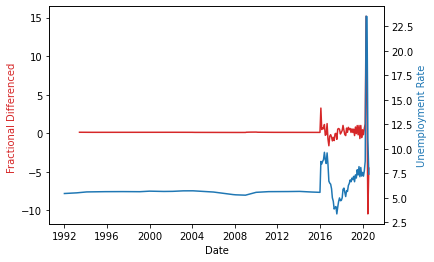

In [ ]:
fig, ax1 = plt.subplots()
 
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Fractional Differenced ', color=color)
ax1.plot( df_result['y'], color=color)
 
ax2 = ax1.twinx()
 
color = 'tab:blue'
ax2.set_ylabel('Unemployment Rate', color = color)
ax2.plot(df['y'], color=color)
 
plt.show()

In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(df_result['y'])
test_result

(-2.3687359414271896,
 0.15075554817938552,
 13,
 313,
 {'1%': -3.4514162625887037,
  '10%': -2.5717136883095675,
  '5%': -2.8708187088091406},
 796.9376788615439)

In [ ]:
#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df_result['y'])

ADF Test Statistic : -2.3687359414271896
p-value : 0.15075554817938552
#Lags Used : 13
Number of Observations Used : 313
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
df_result['y First Difference'] = df_result['y'] - df_result['y'].shift(1)

In [ ]:
## Again test dickey fuller test
adfuller_test(df_result['y First Difference'].dropna())

ADF Test Statistic : -5.950916267271725
p-value : 2.1482928248807832e-07
#Lags Used : 17
Number of Observations Used : 308
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


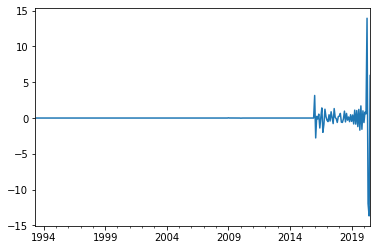

In [ ]:
df_result['y First Difference'].plot()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model=ARIMA(df_result['y'],order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  326
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.971
Method:                       css-mle   S.D. of innovations              1.082
Date:                Mon, 23 Aug 2021   AIC                            989.942
Time:                        15:32:51   BIC                           1005.090
Sample:                    06-30-1993   HQIC                           995.987
                         - 07-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.395      0.693      -0.001       0.002
ar.L1.D.y      0.2198      0.056      3.940      0.000       0.110       0.329
ma.L1.D.y     -1.0000      0.008   -129.921      0.000      -1.015      -0.985
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.5495           +0.0000j            4.5495            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

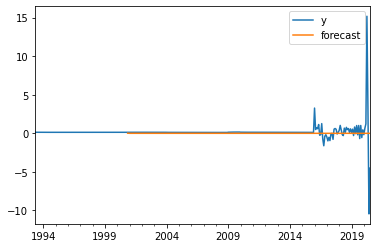

In [ ]:
df_result['forecast']=model_fit.predict(start=90,end=344,dynamic=True)
df_result[['y','forecast']].plot(figsize=(6,4))
plt.savefig("filename3.pdf")

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,18)]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_result.columns)

In [ ]:
future_datest_df

,y,y First Difference,forecast
2020-08-31,NaN,NaN,NaN
2020-09-30,NaN,NaN,NaN
2020-10-31,NaN,NaN,NaN
2020-11-30,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN
2021-01-31,NaN,NaN,NaN
2021-02-28,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN
2021-04-30,NaN,NaN,NaN
2021-05-31,NaN,NaN,NaN


In [ ]:
future_df=pd.concat([df_result,future_datest_df])

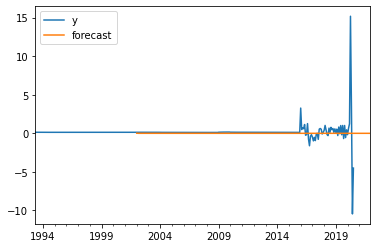

In [ ]:
future_df['forecast'] = model_fit.predict(start = 104, end = 361, dynamic= True)  
future_df[['y', 'forecast']].plot(figsize=(6,4))
plt.savefig("filename7.pdf")

In [ ]:
df_result[-12:]

,y,y First Difference,forecast
2019-08-31,1.016257,1.205470,0.00032
2019-09-30,-0.680344,-1.696601,0.00032
2019-10-31,1.015272,1.695616,0.00032
2019-11-30,-0.554433,-1.569706,0.00032
2019-12-31,0.451829,1.006263,0.00032
2020-01-31,-0.178615,-0.630445,0.00032
2020-02-29,0.650286,0.828901,0.00032
2020-03-31,1.233382,0.583096,0.00032
2020-04-30,15.177558,13.944176,0.00032
2020-05-31,3.229615,-11.947943,0.00032
